# Welcom to this simple introduction to Tensorflow

## 1. Install tensorflow
It is simple to run:

**```sudo pip install tensorflow```**

If you have a GPU card, you can install gpu version. But you should install cuda and cudnn library firstly.

**```sudo pip install tensorflow-gpu```**

GPU version is recommended.

## 2. Basic Concept

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
%matplotlib notebook

In [3]:
g = tf.Graph()

with g.as_default():
    a = tf.placeholder(tf.float32, name="a")
    b = tf.placeholder(tf.float32, name="b")
    c = tf.add(a, b)
    d = tf.placeholder(tf.float32, name="d")
    x = tf.multiply(c, d, name="x")

# Write graph definition to logdir, then tensorboard can read it and draw itin browser.
tf.summary.FileWriter("../logs/basic_add", g).close()

### Display graph
Change workding directory to project root, and execute:  
**```tensorboard --logdir=../logs/basic_add```**

Then open a URL **```http://127.0.0.1:6006```** in your browser, you will get graph picture like this:
![](../logs/images/graph_1.png)


### Run graph

We will get:

**```x = (10+20)*5 = 150```**

In [4]:
# intialize session with the graph we just defined.
with tf.Session(graph=g) as sess:
    # run to get x's value
    x_value = sess.run(x, feed_dict={a:10, b:20, d:5})
    print("Result of x: %f" % x_value)

Result of x: 150.000000


## 3. Toy model to train - Least Squares for linear model

A linear model like:
$$ y = \sum_i x_i w_i + b $$
where $w_i$ is weight for feature $x_i$, and $b$ is bias.

If we take two features ($x_1, x_2$) as example, let $ w_0 = b$, we get,

$$\begin{pmatrix}
y_1 \\
y_2 \\
 \vdots \\
y_N
\end{pmatrix}
=
\begin{pmatrix} 1 & x_{1,1} & x_{2,1} \\
    1 & x_{1,2} & x_{2,2}    \\
    \vdots & \vdots & \vdots \\
    1 & x_{1,N} & x_{2,N}
\end{pmatrix}
\begin{pmatrix}
w_0 \\
w_1 \\
w_2 
\end{pmatrix},$$

where $N$ is total number of samples.

It can be  written in more compact vector format,
$$  Y = X \cdot W $$

Given sample data $(X, Y)$, the most fit $W$ will make the variance least,

$$ \underset{W}{\arg\min} \frac{1}{N} \sum_{i=1}^{N} |y_i - X_iW|^2 $$

There is a analytic solution for least squares,

$$ W = (X^T X)^{-1}X^T Y$$



In [5]:
import numpy as np
import sklearn.linear_model

In [6]:
# set random seed
np.random.seed(12345)

In [100]:
K = 100000      # number of points
D = 2          # number of features
X = np.random.rand(K, 2) * 10.0

# weight
W = np.array([1.5, 2.0])
# bias
b = 5.0

# observation noise. a normal distribution.
noise = np.random.randn(K) * 3   

y = np.dot(X, W) + b     
y = y + noise                    # add noise

### Using the following fomula to define a function to caculate weight and bias.
$$ W = (X^T X)^{-1}X^T Y$$

In [101]:
def fit_linear_least_square(X, y):
    # create a matrix of X, add a auxiliary column
    mX = np.matrix(np.zeros((X.shape[0], X.shape[1]+1), dtype=X.dtype))
    mX[:,0] = 1     # column 0, is all 1
    mX[:,1:] = X
    
    my = np.matrix(y).T
    mW = (mX.T * mX).I * mX.T * my
    
    return mW

Call **```fit_linear_least_square```** we get the weights that fit model.  They are almost same as original ones (10, 1.5, 2.0)

In [102]:
W_fit = fit_linear_least_square(X, y)
print W_fit

[[ 5.01977509]
 [ 1.50181992]
 [ 1.99482274]]


The subpackage linear-model of scikit-learn use the same algorithm. So, we get same result.

In [103]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(X, y)

# coef_ is w, intercept_ is bias 
reg.coef_, reg.intercept_

(array([ 1.50181992,  1.99482274]), 5.0197750897766227)

<IPython.core.display.Javascript object>


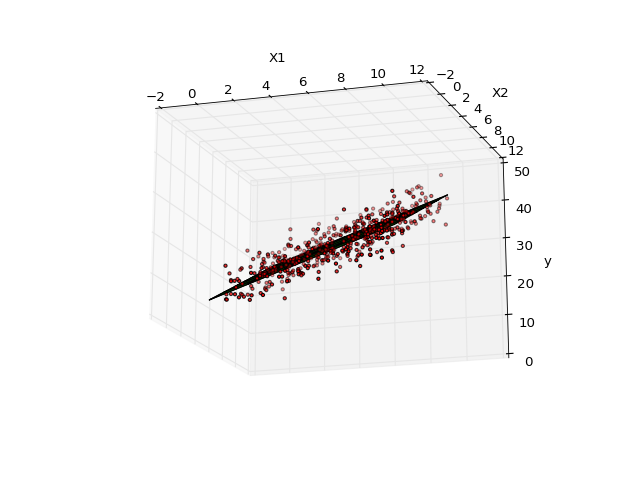

In [104]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# draw the points of samples
idx = np.arange(X.shape[0], step=200)
ax.scatter(X[idx,0], X[idx,1], y[idx], c='r', s=8, marker='o')

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("y")

plt.show()

#### Now, add a fit plane

In [106]:
# draw the fit surface 
xs_1 = np.arange(0, 10, 0.2)
xs_2 = np.arange(0, 10, 0.2)
xs_1, xs_2 = np.meshgrid(xs_1, xs_2, indexing="ij")
ys = reg.coef_[0] * xs_1 + reg.coef_[1] * xs_2 + reg.intercept_

surf = ax.plot_surface(xs_1, xs_2, ys, color='green')

plt.show()

# 4. Fit linear model using mini-batch SGD by Tensorflow

SGD means stochastic gradient decent.
Let loss function,

$$ L(w,b) =  \frac{1}{N} \sum_{i=1}^{N} |y_i^{true} - y_i^{pred}|^2  =  \frac{1}{N} \sum_{i=1}^{N} |y_i^{true} - (WX + b)|^2 $$

To find the most suitable $(w, b)$ to minimalize loss, we can update the paramemter in direction of gradient decending.

$$ w \rightarrow w - \lambda \frac{\partial L}{\partial w}, $$ 

$$ b \rightarrow b - \lambda \frac{\partial L}{\partial b}, $$ 

where $\lambda$ is learning rate.


### Define train operation

In [133]:
D = 2
batch_size = 1000
    
g = tf.Graph()
with g.as_default():

    X_input = tf.placeholder(tf.float32, shape=[batch_size, D], name="X_input")
    y_input = tf.placeholder(tf.float32, shape=[batch_size], name="y_input")
    var_W = tf.get_variable("W", shape=[D,1], dtype=tf.float32, initializer=tf.zeros_initializer)
    var_b = tf.get_variable("b", shape=[], dtype=tf.float32, initializer=tf.zeros_initializer)
    
    y_pred = tf.matmul(X_input, var_W) + var_b
    y_pred = tf.squeeze(y_pred)
    
    # Define loss. It is same as built-in loss op: tf.losses.mean_squared_error
    loss_op = tf.reduce_mean(tf.square(tf.subtract(y_input, y_pred)))
    
    # learning rate
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = tf.contrib.slim.learning.create_train_op(loss_op, optimizer)
    
    init_fn = tf.global_variables_initializer()
    

### Execute training process

In [140]:
from sklearn.model_selection import train_test_split

# split train and validation datasets
X_train, X_validate, y_train, y_validate = \
    train_test_split(X, y, test_size=0.2, random_state=100)

n_batches_per_epoch = X_train.shape[0] / batch_size
n_batches_validate = X_validate.shape[0] / batch_size

# max epoches to train
n_epoches = 50

with tf.Session(graph=g) as sess:
    sess.run(init_fn)
    
    for epoch in range(n_epoches):
        train_losses = np.zeros(n_batches_per_epoch)
        for batch in range(n_batches_per_epoch):
            X_train_batch = X_train[batch*batch_size:(batch+1)*batch_size]
            y_train_batch = y_train[batch*batch_size:(batch+1)*batch_size]
            train_losses[batch] = sess.run(train_op, 
                    feed_dict={X_input:X_train_batch, y_input:y_train_batch, learning_rate:0.01})
    
        # get current value of parameters after a epoch training
        W_value, b_value = sess.run([var_W, var_b])
        
        # more compact format in python
        validate_losses = \
            [ sess.run(loss_op, 
                       feed_dict={ X_input:X_validate[batch*batch_size:(batch+1)*batch_size], 
                                   y_input:y_validate[batch*batch_size:(batch+1)*batch_size]})
                           for batch in range(n_batches_validate) ]
        print("epoch #%d, train loss: %8f, validation loss: %8f, W: [%8f, %8f], b: %8f" % 
              (epoch, np.mean(train_losses), np.mean(validate_losses), 
               W_value[0][0], W_value[1][0], b_value))


epoch #0, train loss: 18.711742, validation loss: 10.983658, W: [1.815441, 2.318214], b: 1.310339
epoch #1, train loss: 10.558094, validation loss: 10.256668, W: [1.754164, 2.256178], b: 2.059538
epoch #2, train loss: 9.982628, validation loss: 9.792614, W: [1.705321, 2.206728], b: 2.656728
epoch #3, train loss: 9.617021, validation loss: 9.496058, W: [1.666388, 2.167312], b: 3.132749
epoch #4, train loss: 9.384747, validation loss: 9.306274, W: [1.635354, 2.135892], b: 3.512187
epoch #5, train loss: 9.237184, validation loss: 9.184606, W: [1.610617, 2.110848], b: 3.814638
epoch #6, train loss: 9.143441, validation loss: 9.106434, W: [1.590899, 2.090886], b: 4.055723
epoch #7, train loss: 9.083891, validation loss: 9.056077, W: [1.575181, 2.074973], b: 4.247893
epoch #8, train loss: 9.046064, validation loss: 9.023534, W: [1.562653, 2.062289], b: 4.401073
epoch #9, train loss: 9.022037, validation loss: 9.002415, W: [1.552667, 2.052179], b: 4.523170
epoch #10, train loss: 9.006776, val

In [66]:
X_train.shape

(80000, 2)